In [2]:
import numpy as np
import pandas as pd
import itertools
import h5py
import matplotlib.pyplot as plt
from scipy import stats
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import linalg
from scipy import signal
from scipy.optimize import curve_fit
import time
from pathlib import Path
import os
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['text.usetex'] = True

import sys
import mpld3

#mpld3.enable_notebook()

sys.path.insert(0, '..')
from modules import prh
from modules import regression as rg

## Load QSO data and instantiate Generator object

In [3]:
file_path = Path('../data/cosmograil_data/HE0435_Bonvin2016.rdb_.txt')

prh_gen = prh.LightCurvePRHGenerator()
prh_gen.loadQSODataFromFile(file_path)

### Estimate structure function from data

By default it is a power law fit; let's use it like it is for now

In [4]:
prh_gen.evaluateStructureFunction()
prh_gen.fitStructureFunctionModel()

### Generate a dataset for a given delay

Let's generate a dataset of 100 MC realizations of light curves pairs, all with a relative time delay of 50 days

In [7]:
true_delay = 50
N_MC_samples = 100

outfile_name = f'{prh_gen.qso_id}_delay_{true_delay}d_NMC_{N_MC_samples}.h5'
outfile = Path('../aux') / outfile_name

In [9]:
prh_gen.generatePRHDatasetForDelay(true_delay=true_delay, N_MC_samples=N_MC_samples, outfile=outfile)

### Load the dataset

Instantiate dataset class and load from file the dataset you have just generated

In [10]:
dataset = prh.LightCurvePRHDataset(input_file=outfile)

First of all get the true QSO data

In [11]:
qso_data = dataset.getOriginalQSOData()

t = qso_data['time_domain'][()]
qso_lc_vals = qso_data['qso_light_curve_values'][()]
qso_lc_errs = qso_data['qso_light_curve_errors'][()]

Extract a given realization from the dataset, using an index from 1 to N_MC_samples, along with its errors. At the moment the errors on the MC realizations are the same of the original data errors

In [12]:
r = dataset.getMCRealization(5)

yA = r['yA'][()]
yB = r['yB'][()]
errA = r['errA'][()]
errB = r['errB'][()]

Some plots

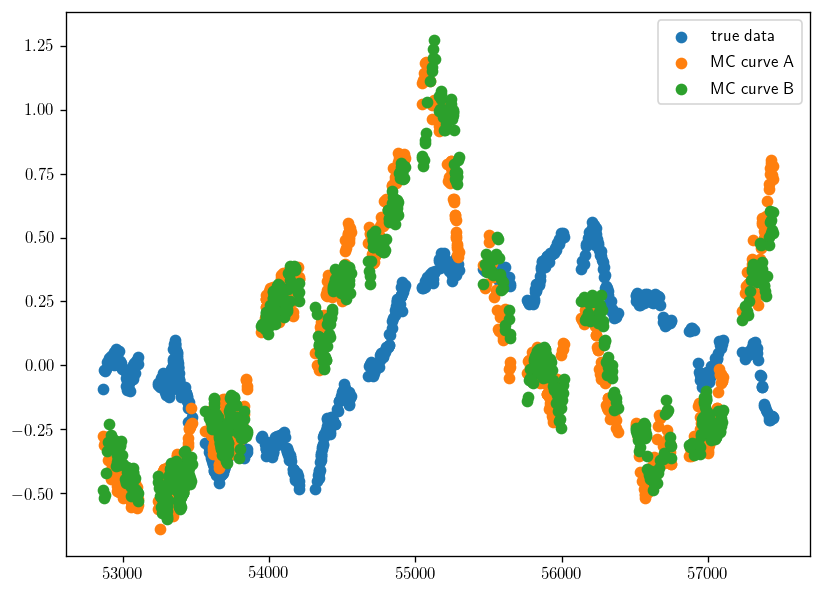

In [13]:
plt.figure()
plt.scatter(t, qso_lc_vals - qso_lc_vals.mean(), label='true data')
plt.scatter(t, yA - yA.mean(), label='MC curve A')
plt.scatter(t, yB - yB.mean(), label='MC curve B')
plt.legend()

Some insights in the procedure; first of all fit two gaussian processes to the MC data

In [14]:
kernel = ConstantKernel(2, (1e-3, 1e2)) * Matern(length_scale=200.0, length_scale_bounds=(1, 300), nu=1.5)

gpA = rg.fit_GP_to_lightcurve(t, yA, errA, kernel)
gpB = rg.fit_GP_to_lightcurve(t, yB, errB, kernel)

Define new time support vector choosing a step, and predict using gaussian on this new support

In [15]:
gp_step = 10.0
support = np.arange(t[0] - 50, t[-1] + 50, gp_step)

ypredA, sigmaA = gpA.predict(np.expand_dims(support, 1), return_std=True)
ypredB, sigmaB = gpB.predict(np.expand_dims(support, 1), return_std=True)

Plot the results at a given confidence level, along with the MC data

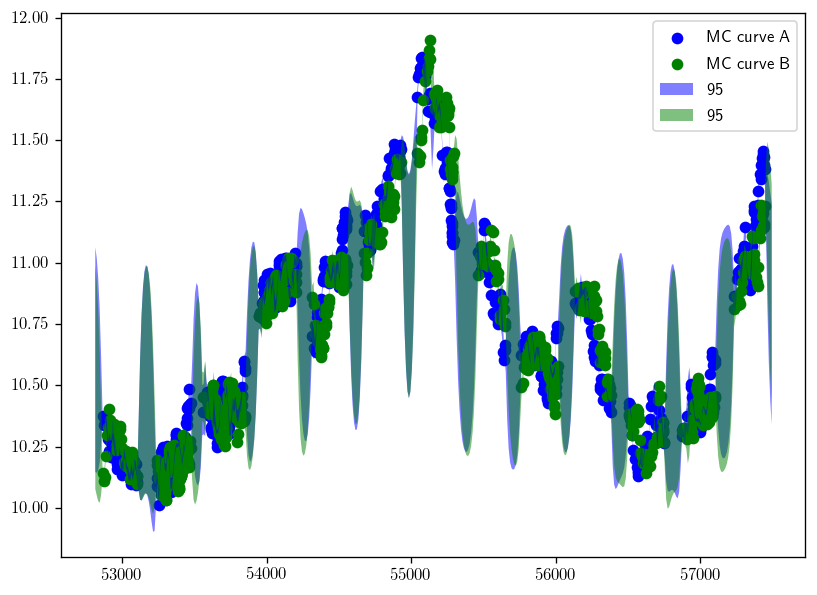

In [16]:
CL = 0.95

plt.scatter(t, yA, label='MC curve A', color='b')
plt.scatter(t, yB, label='MC curve B', color='g')

plt.fill_between(support, ypredA - special.erfinv(CL)*sigmaA, ypredA + special.erfinv(CL)*sigmaA,
         alpha=.5, fc='b', ec='None', label='95% confidence interval A')
plt.fill_between(support, ypredB - special.erfinv(CL)*sigmaB, ypredB + special.erfinv(CL)*sigmaB,
         alpha=.5, fc='g', ec='None', label='95% confidence interval B')
plt.legend(fontsize=10)

In [17]:
dt_estimate = rg.time_delay_grid_search(ypredA, ypredB,
                                        sigmaA, sigmaB,
                                        gp_step,
                                        dt_min=0, dt_max=100)

In [18]:
print(dt_estimate)

50.0


To directly get an estimate of the time delay between the MC curves, without doing the intermediate steps (they are all in the following function) do:

In [19]:
dt_estimate = rg.estimate_delay(t, yA, yB, errA, errB)

print(f'Estimated delay: {dt_estimate}')

Estimated delay: 49.800000000000004
